# MC simulation for ToF of a particle in 1D

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def simulate_telegraph_continuous(tau: float, t_max: float, v0: float = 1.0, x0: int | None = None):
    """
    Retourne
    --------
    times_full : np.ndarray
        Instants incluant t=0, les dates de changement et t_max.
    positions  : np.ndarray
        Position de la particule à ces instants (trajectoire continue).
    xs_full    : np.ndarray
        Signal directionnel (utile si on veut superposer).
    """
    if x0 is None:
        x = random.choice([-1, 1])
    elif x0 in (-1, 1):
        x = x0
    else:
        raise ValueError("x0 doit être ±1")

    t = 0.0
    times = [t]
    xs = [x]

    # Génération des dates de changement
    while t < t_max:
        dt = random.expovariate(1.0 / tau)
        t += dt
        if t > t_max:
            break
        x = random.choice([-1, 1])
        times.append(t)
        xs.append(x)

    # Construction des tableaux complets
    times_full = np.append(times, t_max)
    xs_full = np.append(xs, xs[-1])

    # Intégration de la vitesse
    dt = np.diff(times_full)
    displacements = v0 * xs_full[:-1] * dt
    positions = np.concatenate(([0.0], np.cumsum(displacements)))

    return times_full, positions, xs_full


## Démo

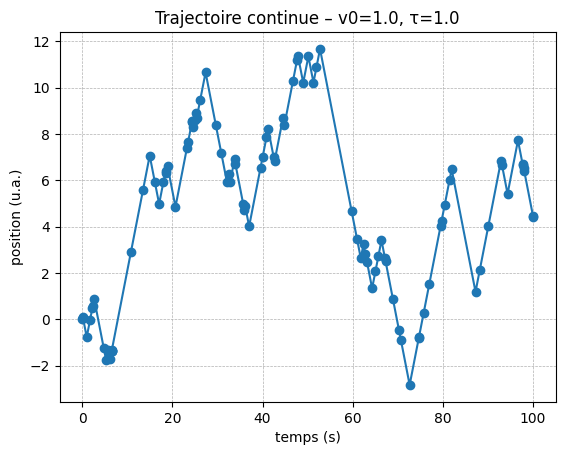

In [3]:
tau, t_max, v0 = 1.0, 100.0, 1.0
times_full, positions, xs_full = simulate_telegraph_continuous(tau, t_max, v0, x0=1)

plt.plot(times_full, positions, marker='o')
plt.xlabel("temps (s)")
plt.ylabel("position (u.a.)")
plt.title(f"Trajectoire continue – v0={v0}, τ={tau}")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [4]:
def hitting_probability(L: float, tau: float, v0: float = 1.0, n_sims: int = 20000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    success = 0
    for _ in range(n_sims):
        pos = 0.0
        direction = 1
        while True:
            dt = rng.exponential(scale=tau)
            pos_new = pos + direction * v0 * dt
            if direction == 1:
                if pos_new >= L:
                    success += 1
                    break
            else:
                if pos_new < 0:
                    break
            pos = pos_new
            direction = rng.choice([-1, 1])
    p = success / n_sims
    se = np.sqrt(p * (1 - p) / n_sims)
    return p, se

In [5]:
# Parameters
L = 5.0
v0 = 1.0
n_sims = 20000
tau_values = np.linspace(0.1, 5.0, 25)

probs = []
errors = []
rng = np.random.default_rng(42)
for tau in tau_values:
    p_hat, se = hitting_probability(L, tau, v0, n_sims, rng)
    probs.append(p_hat)
    errors.append(se)

probs = np.array(probs)
errors = np.array(errors)

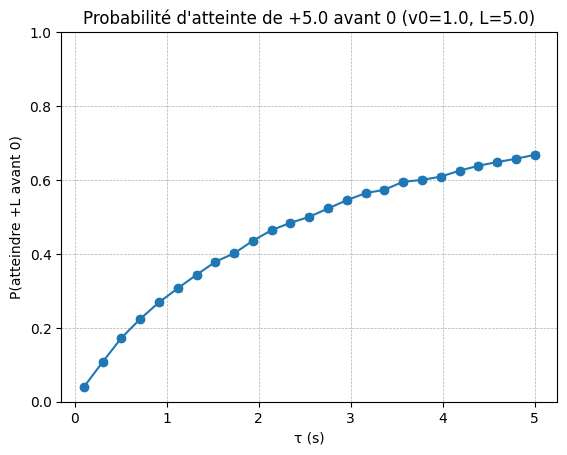

In [6]:
# Plot
plt.errorbar(tau_values, probs, yerr=1.96*errors, fmt='-o', capsize=3)
plt.xlabel("τ (s)")
plt.ylabel("P(atteindre +L avant 0)")
plt.title(f"Probabilité d'atteinte de +{L} avant 0 (v0={v0}, L={L})")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 1)
plt.show()

In [7]:
def mean_hitting_time(L: float, tau: float, v0: float = 1.0, n_sims: int = 20000, rng=None):
    """
    Retourne <T | succès> et son erreur-type.
    """
    if rng is None:
        rng = np.random.default_rng()
    times = []
    for _ in range(n_sims):
        pos = 0.0
        direction = 1
        t = 0.0
        while True:
            dt = rng.exponential(scale=tau)
            t += dt
            pos_new = pos + direction * v0 * dt
            if direction == 1 and pos_new >= L:
                times.append(t)
                break
            if direction == -1 and pos_new < 0:
                break
            pos = pos_new
            direction = rng.choice([-1, 1])
    if not times:
        return np.nan, np.nan
    times = np.array(times)
    return times.mean(), times.std(ddof=1) / np.sqrt(len(times))

In [8]:
# Paramètres
L = 5.0
v0 = 1.0
n_sims = 2000
tau_values = np.concatenate((np.linspace(0.1,1.0,10), np.linspace(1.0, 5.0, 15)))

mean_times, errors = [], []
rng = np.random.default_rng(123)
for tau in tau_values:
    m, se = mean_hitting_time(L, tau, v0, n_sims, rng)
    mean_times.append(m)
    errors.append(se)

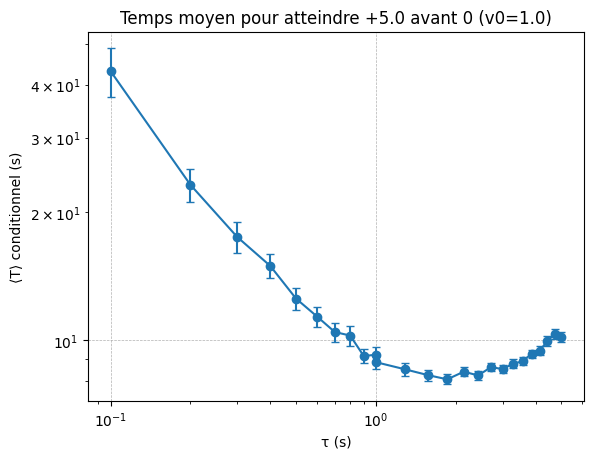

In [12]:
plt.errorbar(tau_values, mean_times, yerr=1.96*np.array(errors), fmt='-o', capsize=3)
plt.xlabel("τ (s)")
plt.ylabel("⟨T⟩ conditionnel (s)")
plt.xscale("log") 
plt.yscale("log")
plt.title(f"Temps moyen pour atteindre +{L} avant 0 (v0={v0})")
plt.grid(True, linestyle='--', linewidth=0.5)
# plt.ylim(bottom=0)
plt.show()